In [25]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 23 10:55:17 2016

Three files needed:
- us_counties_500k.json (was provided in bayeshack repository)
- bayes_viirs_centiles.csv (preprocessed from R file)
- full_county_file.csv (preprocessed from R file)

@author: pschuber
"""
%matplotlib inline
import multiprocessing
import pandas as pd
import geojson
import matplotlib.pyplot as plt 
from descartes import PolygonPatch
import numpy as np
import shapely.geometry as geom
plt.style.use('ggplot')
import matplotlib.cm as cm
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import KFold
p_data = os.path.expanduser('~') + '/devel/bayeshack-commerce-satellite/data/'

def get_county_areas():
    """
    Extract area for counties from us_counties_500k.json.
    return: dictionary containing values polygons, area and state with keys of corresponding county code.
    """
    with open(p_data + "/util/us_counties_500k.json") as json_file:
        counties_geo = geojson.loads(json_file.read().decode("ISO-8859-1"))
    county_dict = {}
    for county in counties_geo["features"]:
        county_code = int(county["properties"]["STATE"] + county["properties"]["COUNTY"])           
        polygon = county["geometry"]
        area = geom.shape(polygon).area
        polygons = []
        if polygon["type"] == 'MultiPolygon':
            for subpoly in polygon["coordinates"]:
                polygons.append({"type": "Polygon", "coordinates": subpoly})
        else:
            polygons.append(polygon)    
        county_dict[county_code] = {"polygons": polygons, "area": area, "state": county["properties"]["STATE"]}
    return county_dict
       
def restrict_dates(df):
    """
    Return panda dataframe truncated before 02/2014 and after 06/2015. Found to be the overlapp
    of emplyoment and luminosity data.
    """
    res_2014 = df[(df["year"] == 2014)].copy()
    res_2014 = res_2014[res_2014["month"] > 1]
    res_2015 = df[df["year"] == 2015].copy()
    res_2015 = res_2015[res_2015["month"] < 7]
    return pd.concat([res_2014, res_2015])

def county_lum_per_month():
    """
    Get luminosity of counties per month as dataframe.
    """
    counties = pd.read_csv(p_data + 'bayes_viirs_centiles.csv')
    return restrict_dates(counties)
    
def bls_per_month():
    """
    Get employment of counties per month as dataframe.
    """
    employment = pd.read_csv(p_data + 'full_county_file.csv')
    employment = employment.rename(columns={'mo': 'month'})
    employment.drop('agglvl_code', axis=1, inplace=True)
    employment.drop('industry_code', axis=1, inplace=True)
    return restrict_dates(employment)
     
def merge_bls_lum():
    """
    Merge luminosity and employment of counties per month as dataframe.
    """
    county_areas = get_county_areas()
    bls = bls_per_month()
    luminosity = county_lum_per_month()
    res = luminosity.head(0) + pd.DataFrame(columns=["emp", "area"])
    overlap = set(bls["area_fips"]).difference(set(luminosity["GEOID"]))
    overlap = list(overlap)
    for _el in luminosity.iterrows():
        print _el[0] 
        el = _el[1].copy()
        m = el["month"]
        fips = el["GEOID"]
        y = el["year"]
        query = bls["emp"][(bls["area_fips"]==fips) & (bls["month"]==m) & (bls["year"]==y)]
        if query.nunique()!=0:
            curr_ix = res.shape[0]
            res.loc[curr_ix] = el.copy()
            res.set_value(curr_ix, "emp", query.as_matrix()[0])
            area = county_areas[fips]['area']
            res.set_value(curr_ix, "area", area)   
    return res   

# gather combined data of luminosity and employment rate and write it to data directory
if not os.path.isfile(p_data + "viirs_emp.csv"):
    viirs_emp = merge_bls_lum()
    viirs_emp.to_csv(p_data + "viirs_emp.csv")
orig_df = pd.read_csv(p_data + "viirs_emp.csv")

## Densities colored by time

arr consists of entries Index([u'GEOID', u'area', u'char', u'emp', u'month', u'sum', u'year'], dtype='object')


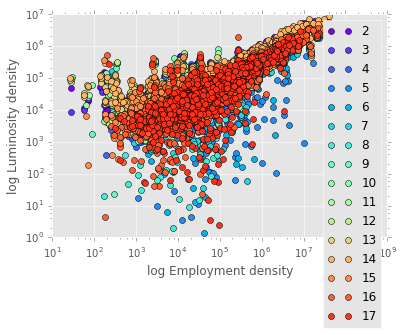

In [26]:
viirs_emp = pd.read_csv(p_data + "viirs_emp.csv")

# drop unnecessary centiles
for i in range(101):
    viirs_emp.drop('pct.%d' % i, axis=1, inplace=True)
viirs_emp.drop('Unnamed: 0', axis=1, inplace=True)
arr = viirs_emp.as_matrix().astype(np.float)
print "arr consists of entries", viirs_emp.head(0).columns
arr[:, 4][arr[:, -1] == 2015.] = arr[:, 4][arr[:, -1] == 2015.] + 12

# plot monthly colored densities
# find direct correlation between employment density and luminosity density
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, 17))
for i, c in zip(range(2, 18), colors):
    plt.loglog(arr[arr[:, 4]==i][:, 3]/arr[arr[:, 4]==i][:, 1], arr[arr[:, 4]==i][:, -2]/arr[arr[:, 4]==i][:, 1], 'o', color=c, label='%d' % i)
plt.xlabel("log Employment density")
plt.ylabel("log Luminosity density")
plt.legend()
plt.show() 
# plt.savefig(p_data + "densities.png", dpi=300)
   

## Density Differences by Time

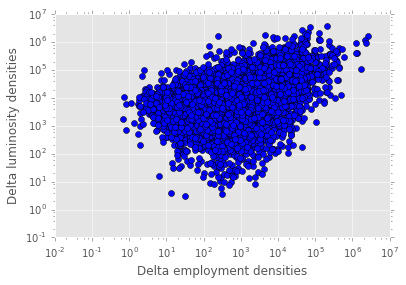

In [27]:
# plot the log delta densities
plt.figure()
for k, fips in enumerate(list(set(arr[:, 0]))):
    curr_county = arr[arr[:, 0] == fips]
    curr_county = curr_county[np.argsort(curr_county[:, 4])]
    curr_county[:, 3] /= curr_county[:, 1]
    curr_county[:, -2] /= curr_county[:, 1]
    delta_emp_dens = curr_county[1:, 3] - curr_county[:-1, 3]
    delta_lum_dens = curr_county[1:, -2] - curr_county[:-1, -2]
    plt.loglog(delta_emp_dens, delta_lum_dens, 'bo')
    plt.xlabel("Delta employment densities")
    plt.ylabel("Delta luminosity densities")
plt.show()
# plt.savefig(p_data + "deltas.png", dpi=300)

## RandomForestRegressor -- Inference of Employment

Performing a time independent regression of luminosity features and employment density.

In [30]:
cpu_cnt = multiprocessing.cpu_count()
number_folds = 5
scores = []

# calculate densities, i.e. features X and target values Y for all data
emp_dens = arr[:, 3]/arr[:, 1]
lum_dens = arr[:, -2]/arr[:, 1]
X = np.concatenate((orig_df.as_matrix()[:, 6:-3], lum_dens[:, None]), axis=1)
Y = emp_dens

# Random Forest Regression Model to regress employment density from
# luminosity percentiles and luminosity density
kf = KFold(arr.shape[0], n_folds=number_folds)
for train_index, test_index in kf:
    rfc = RandomForestRegressor(n_estimators=60, n_jobs=cpu_cnt, max_features=0.33)
    rfc.fit(X[train_index], Y[train_index])
    scores.append(rfc.score(X[test_index], Y[test_index]))
    print scores[-1]
print "Result of %d-fold evaluation: %0.3f +- %0.3f" % (number_folds, np.mean(scores),
                                                        np.std(scores)/np.sqrt(number_folds))
names = orig_df.head(0).columns[6:-3]
names = np.array(names.tolist()+['lum_dens'])
print names[np.argsort(rfc.feature_importances_)][::-1] # most important features first

-0.0908171206022
0.434339112416
0.756767307394
0.417273447502
0.785848652742
Result of 5-fold evaluation: 0.461 +- 0.141
['pct.98' 'pct.0' 'pct.9' 'pct.1' 'pct.5' 'pct.7' 'pct.97' 'lum_dens'
 'pct.3' 'pct.37' 'pct.100' 'pct.35' 'pct.8' 'pct.2' 'pct.6' 'pct.96'
 'pct.61' 'pct.36' 'pct.64' 'pct.74' 'pct.83' 'pct.69' 'pct.38' 'pct.33'
 'pct.90' 'pct.51' 'pct.71' 'pct.58' 'pct.23' 'pct.66' 'pct.76' 'pct.25'
 'pct.62' 'pct.60' 'pct.50' 'pct.88' 'pct.28' 'pct.43' 'pct.75' 'pct.39'
 'pct.91' 'pct.67' 'pct.68' 'pct.27' 'pct.87' 'pct.41' 'pct.29' 'pct.65'
 'pct.73' 'pct.34' 'pct.15' 'pct.40' 'pct.94' 'pct.72' 'pct.30' 'pct.17'
 'pct.84' 'pct.89' 'pct.92' 'pct.10' 'pct.45' 'pct.55' 'pct.78' 'pct.46'
 'pct.31' 'pct.44' 'pct.16' 'pct.49' 'pct.32' 'pct.56' 'pct.4' 'pct.86'
 'pct.79' 'pct.93' 'pct.48' 'pct.57' 'pct.11' 'pct.59' 'pct.95' 'pct.81'
 'pct.54' 'pct.53' 'pct.42' 'pct.52' 'pct.24' 'pct.12' 'pct.80' 'pct.70'
 'pct.82' 'pct.47' 'pct.18' 'pct.85' 'pct.22' 'pct.26' 'pct.13' 'pct.14'
 'pct.21' 